# Data Loading

In [59]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df = spark.read \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dog_caract2_formatted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", driver_class) \
    .load()


df.show()
df.count()

+--------------------+------------+------------+--------------------+-------+---+-------------+--------------------+--------------------+------------------+--------------------+
|            bred_for| breed_group|country_code|         description|history| id|    life_span|                name|              origin|reference_image_id|         temperament|
+--------------------+------------+------------+--------------------+-------+---+-------------+--------------------+--------------------+------------------+--------------------+
|Small rodent hunt...|         Toy|        NULL|                NULL|   NULL|  1|10 - 12 years|       Affenpinscher|     Germany, France|         BJa4kxc4X|Stubborn, Curious...|
|Coursing and hunting|       Hound|          AG|                NULL|   NULL|  2|10 - 13 years|        Afghan Hound|Afghanistan, Iran...|         hMyT4CDXR|Aloof, Clownish, ...|
|  A wild pack animal|        NULL|        NULL|                NULL|   NULL|  3|     11 years| African Huntin

344

# Missings Treatment

In [71]:
total_missings, missing_cols = 0, []

ids = spark.createDataFrame([], schema=df.schema)
ids = ids.select(col('id'))

for name, dtype in df.dtypes:
    try:
        filtered_df = df.where(col(name).isNull()) # Trobem valors nuls
        filtered_df = filtered_df.union(df.where(col(name) == '')) # Trobem els valors buits
        ids = ids.union(filtered_df.select(col('id'))).distinct()
        class_count = filtered_df.groupBy(name).count()
        number_of_missings = class_count.first()["count"]
        print(f'Missings for variable {name}: {number_of_missings}')
        missing_cols.append(name)
    except TypeError:
        print(f"No Missing Values found on variable {name}")

Missings for variable bred_for: 4
Missings for variable breed_group: 2
No Missing Values found on variable id
No Missing Values found on variable name
No Missing Values found on variable temperament


In [61]:
total_missings = ids.count()

print(total_missings)

172


Tenim més columnes amb missings que el nombre total de missings perquè la variable id es troba repetida, i per tant, el que veiem és que tenim 172 gossos de races diferents amb columnes amb null values.

### Delete redundant columns

In [62]:
# Aquestes columnes tenen 320, 342, 340, 334 files amb missings respectivament
# Això son valors molt considerables si tenim en compte que el total de files és 344
cols_missings = ["country_code", "description", "history", "origin"]

# Aquestes columnes ja les trobem en taula de dog_caract, així que les treiem per a no tenir redundància
cols_redundant = ["life_span"]

# Aquesta no ens aporta cap informació ja que no usarem imatges
cols_not_useful = ["reference_image_id"]

df = df.drop(*cols_missings+cols_redundant+cols_not_useful)

df.show()

+--------------------+------------+---+--------------------+--------------------+
|            bred_for| breed_group| id|                name|         temperament|
+--------------------+------------+---+--------------------+--------------------+
|Small rodent hunt...|         Toy|  1|       Affenpinscher|Stubborn, Curious...|
|Coursing and hunting|       Hound|  2|        Afghan Hound|Aloof, Clownish, ...|
|  A wild pack animal|        NULL|  3| African Hunting Dog|Wild, Hardworking...|
|Badger, otter hun...|     Terrier|  4|    Airedale Terrier|Outgoing, Friendl...|
|      Sheep guarding|     Working|  5|          Akbash Dog|Loyal, Independen...|
|       Hunting bears|     Working|  6|               Akita|Docile, Alert, Re...|
|            Guarding|       Mixed|  7|Alapaha Blue Bloo...|Loving, Protectiv...|
|        Sled pulling|       Mixed|  8|       Alaskan Husky|Friendly, Energet...|
|Hauling heavy fre...|     Working|  9|    Alaskan Malamute|Friendly, Affecti...|
|               

### Impute missings

In [72]:
for name, data_type in df.dtypes:        
    if name in missing_cols:
        if data_type == 'string':

            #  Agrupem els diferents valors de la columna
            grouped_df = df.groupBy(col(name))

            value_counts = grouped_df.count()

            # Els ordenem de més comuns a menys
            sorted_counts = value_counts.orderBy(col('count').desc())

            # Comprovem si el primer valor és el valor null
            first_value = sorted_counts.first()[0]
            if first_value is None: 
                # Si ho és, agafem el segon valor
                most_common_value = sorted_counts.limit(2).collect()[1][name] # De les dues primeres files, ens quedem amb la segona
            else:
                most_common_value = sorted_counts.first()[name]
                
            print(f"value imputed for {name}:", most_common_value)

            udf = UserDefinedFunction(lambda x: most_common_value if x==None or x=='' else x, data_type)

            df = df.select(*[udf(column).alias(name) if column == name else column for column in df.columns])


value imputed for bred_for: Lapdog
value imputed for breed_group: Working


Comprovem que no queden missings:

In [73]:
total_missings, missing_cols = 0, []

ids = spark.createDataFrame([], schema=df.schema)
ids = ids.select(col('id'))

for name, dtype in df.dtypes:
    try:
        filtered_df = df.where(col(name).isNull()) # Trobem valors nuls
        filtered_df = filtered_df.union(df.where(col(name) == '')) # Trobem els valors buits
        ids = ids.union(filtered_df.select(col('id'))).distinct()
        class_count = filtered_df.groupBy(name).count()
        number_of_missings = class_count.first()["count"]
        print(f'Missings for variable {name}: {number_of_missings}')
        missing_cols.append(name)
    except TypeError:
        print(f"No Missing Values found on variable {name}")

No Missing Values found on variable bred_for
No Missing Values found on variable breed_group
No Missing Values found on variable id
No Missing Values found on variable name
No Missing Values found on variable temperament


# Data Distribution Visualization

Nombre de categories diferents: 125
Nombre de categories diferents: 8


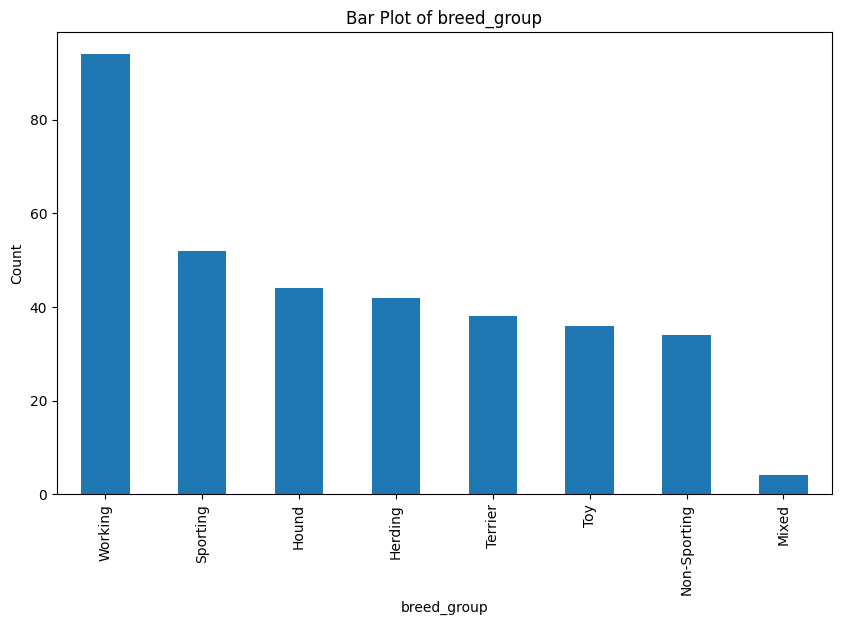

Nombre de categories diferents: 166


In [74]:
df_pd = df.toPandas()

columnes_categoriques = ["bred_for", "breed_group", "temperament"]

for column in columnes_categoriques:
    # Contem el nombre d'elements de cada columna
    value_counts = df_pd[column].value_counts()

    counts = value_counts.count()
    print("Nombre de categories diferents:", counts)

    # Si hi ha suficients pocs valors diferents com per a que el bar plot sigui interpretable
    if counts < 20: 
        # Fem el plot
        value_counts.plot(kind='bar', figsize=(10, 6))
        plt.title(f'Bar Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()
    

Veiem com al imputar els missings com a Working, que era la categoria més comuna, aquesta destaca encara més del que ho hauria fet. La resta de categories es mouen entre les 50 i les 30 mostres, excepte la mixed que en té moltes menys. Veiem com els grups més grans de races presents al nostre dataset són actives (pensats per a feines o esport).

# Variable Renaming

In [76]:
# The variable that needs to be renamed in order for our data to be joined
df = df.withColumnRenamed("name", "Breed")
df.columns

['bred_for', 'breed_group', 'id', 'Breed', 'temperament']

# Data Storage

In [78]:
jdbc_url = "jdbc:postgresql://localhost:5432/bda_p1"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "postgres"
connectionProperties = {"user": user, "password": password}


df.write \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver_class) \
  .option("dbtable", "dog_caract2_trusted") \
  .option("user", connectionProperties["user"]) \
  .option("password", connectionProperties["password"]) \
  .mode("append") \
  .jdbc(jdbc_url,"dog_caract2_trusted")